In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import tensorflow_probability as tfp

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, bnn_utils, outlier_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri, bnn_fmri_ae

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=4000
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, val_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    _, train_x=train_data
    _, val_x=val_data
    
    train_x = train_x.astype('float32')
    val_x = val_x.astype('float32')

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [2]:
train_x = train_x[:100]

## Remove outlier values

In [3]:
iqr = outlier_utils.IQR()
iqr.fit(train_x)
#train_x = iqr.transform(train_x, channels_last=False)

In [4]:
batch_size=1
learning_rate=0.001
skip_connections=True
maxpool=True
batch_norm=True
n_channels=4
latent_dimension=(5,5,5)
kernel_size=(9,9,4)
stride_size=(1,1,1)
n_stacks=3

optimizer = tf.keras.optimizers.Adam(learning_rate)

train_set = tf.data.Dataset.from_tensor_slices((train_x, train_x)).batch(batch_size)
dev_set = tf.data.Dataset.from_tensor_slices((val_x, val_x)).batch(1)

## Start playing with uncertainty

In [82]:
from models import bnn_fmri_ae

import importlib
importlib.reload(bnn_fmri_ae)

def create_bayesian_model(input_shape, output_shape, latent_shape, kernel_size, stride_size, n_channels,
                        maxpool=True, batch_norm=True, weight_decay=0.000, skip_connections=False,
                        n_stacks=3, local=True, local_attention=False, MAP=False, outfilter=1):
    
    model = bnn_fmri_ae.BNN_fMRI_AE(latent_shape, output_shape, 
                    kernel_size, stride_size, n_channels,
                    maxpool=maxpool, batch_norm=batch_norm,
                    skip_connections=skip_connections, n_stacks=n_stacks, 
                    local=local, local_attention=local_attention, MAP=MAP, outfilter=outfilter)
    
    
    
    model.build(input_shape=(None,)+input_shape)
    
    return model

#outfilter=0: means no filter at the end
#outfilter=1: conv 1x1 filter variational layer
#outfilter=2: locally connected 1x1 filter variational layer
model = create_bayesian_model(train_x.shape[1:], train_x.shape[1:], latent_dimension,
                    kernel_size, stride_size, n_channels,
                    maxpool=maxpool, batch_norm=batch_norm,
                    skip_connections=skip_connections, n_stacks=n_stacks, 
                    local=True, local_attention=False, MAP=True, outfilter=0)

In [83]:
model.summary()

Model: "bnn_f_mri_ae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         [(None, 64, 64, 30, 1), ( 15633885  
Total params: 15,633,885
Trainable params: 15,633,805
Non-trainable params: 80
_________________________________________________________________


In [84]:
# loss gamma prior over estimate of true parameter \sigma
import math

def gamma_prior_loss(y_true, y_pred):
    l2_dist = ((y_pred[0] - y_true)**2)/2
    beta = tf.math.abs(y_pred[2])+1e-9#y_pred[2]
    alpha = tf.math.abs(y_pred[1])+1e-9#y_pred[1]
    
    #print(tf.reduce_mean(l2_dist))
    #return tf.reduce_mean((beta+l2_dist)*y_true - (alpha+1)*tf.math.log((beta+l2_dist)*y_true), axis=(1,2,3))
    #return tf.reduce_mean((beta+l2_dist)*y_true - alpha*((beta+l2_dist)*y_true), axis=(1,2,3))
    #return tf.reduce_mean(tf.math.cos(beta+l2_dist)*y_true - alpha*(tf.math.sin(beta+l2_dist)*y_true), axis=(1,2,3))
    #return tf.reduce_mean(tf.math.cos(beta+l2_dist)*y_true - alpha*(tf.math.cos(beta+l2_dist+math.pi)*y_true), axis=(1,2,3))
    return tf.reduce_mean(-tf.math.cos(beta+l2_dist)*y_true - alpha*(tf.math.sin(beta+l2_dist)*y_true), axis=(1,2,3)) + tf.norm(alpha) + tf.norm(beta)


In [85]:
start_time = time.time()

#loss_k = bnn_utils.extended_balance(1/10000)
#loss_fn = loss_k.combined_abs_balanced_loss
#loss_fn = bnn_utils.combined_abs_diff_loss
loss_fn=gamma_prior_loss

#train
train_loss, val_loss, parameters_history, l2loss_history = train.train(train_set, model, optimizer, 
                                                           loss_fn, epochs=10, 
                                                           val_set=dev_set, verbose=True, verbose_batch=False)

print("Time training: ", time.time()-start_time)

Epoch 1 with loss: 27.2676965200901
Epoch 2 with loss: 1.4100174939632415
Epoch 3 with loss: 0.924096771478653
Epoch 4 with loss: 0.7614631199836731
Epoch 5 with loss: 0.7338681703805924
Epoch 6 with loss: 0.6803329700231552


KeyboardInterrupt: 

# Compute aleatoric uncertainty and epistemic uncertainty

#### Plot Ground truth, Predicted, Aleatoric Uncertainty and Epistemic Uncertainty

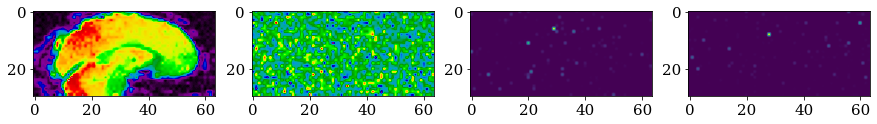

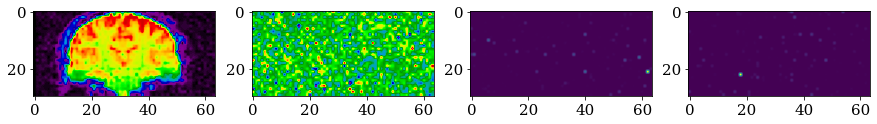

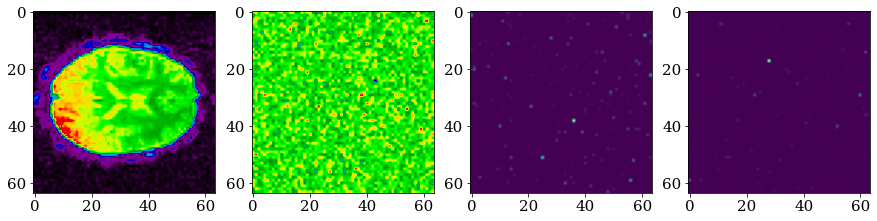

In [86]:
from scipy.ndimage import rotate

volume=10
xslice=30
yslice=30
zslice=15
array_set=train_x

fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,xslice,:,:,:], 90),cmap=plt.cm.nipy_spectral)
axes[1].imshow(rotate(model(array_set[volume:volume+1])[0].numpy()[0,xslice,:,:,:], 90, axes=(0,1)),cmap=plt.cm.nipy_spectral)
axes[2].imshow(rotate(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
axes[3].imshow(rotate(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,:,yslice,:,:], 90),cmap=plt.cm.nipy_spectral)
axes[1].imshow(rotate(model(array_set[volume:volume+1])[0].numpy()[0,:,yslice,:,:], 90, axes=(0,1)),cmap=plt.cm.nipy_spectral)
axes[2].imshow(rotate(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
axes[3].imshow(rotate(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(array_set[volume,:,:,zslice,:],cmap=plt.cm.nipy_spectral)
axes[1].imshow(model(array_set[volume:volume+1])[0].numpy()[0,:,:,zslice,:],cmap=plt.cm.nipy_spectral)
axes[2].imshow(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
axes[3].imshow(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
plt.show()

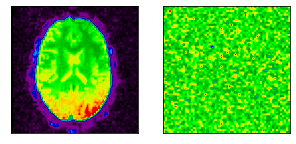

In [87]:
from scipy.ndimage import rotate

volume=5
xslice=30
yslice=30
zslice=15
array_set=train_x


fig, axes = plt.subplots(1, 2, figsize=(5,10))
axes[0].imshow(rotate(array_set[volume,:,:,zslice,:], 90, axes=(0,1)),cmap=plt.cm.nipy_spectral)
axes[1].imshow(rotate(model(array_set[volume:volume+1])[0].numpy()[0,:,:,zslice,:], 90, axes=(0,1)),cmap=plt.cm.nipy_spectral)

axes[0].axes.xaxis.set_visible(False)
axes[0].axes.yaxis.set_visible(False)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
plt.show()

array([[-1.34664525e+00, -3.07687273e-01],
       [-1.58866960e+00, -9.45221318e-02],
       [-1.49972036e+00, -3.37702107e-02],
       [-1.73293413e+00, -1.99787209e-02],
       [-1.88888214e+00, -4.77828285e-03],
       [-2.26049184e+00,  1.01213152e-04],
       [-2.27472920e+00, -9.48727362e-04],
       [-2.80436837e+00, -8.14005433e-05],
       [-2.91965717e+00,  1.48782618e-04],
       [-3.05724917e+00, -1.84433587e-04]])

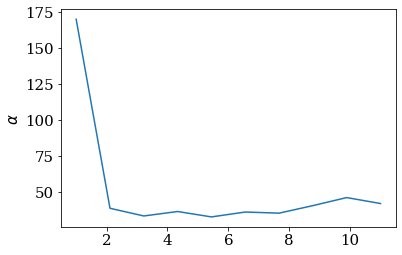

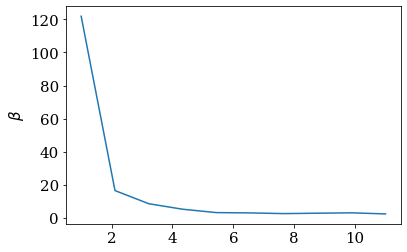

In [88]:

plt.figure()
plt.plot(np.linspace(1,11,10), np.abs(np.array(parameters_history)[:,0])+1e-9)
plt.ylabel("$\\alpha$")
plt.show()

plt.figure()
plt.plot(np.linspace(1,11,10), np.abs(np.array(parameters_history)[:,1])+1e-9)
plt.ylabel("$\\beta$")
plt.show()

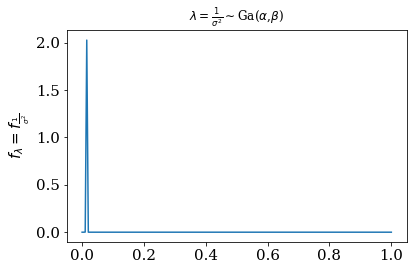

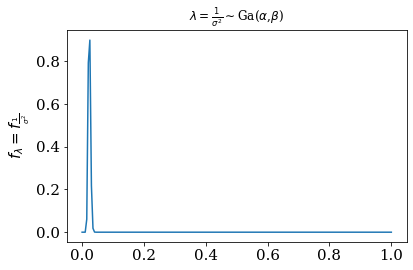

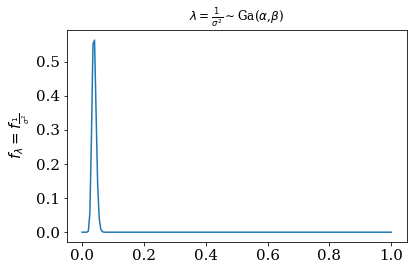

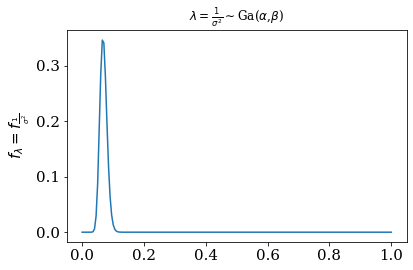

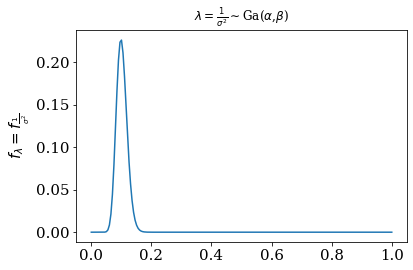

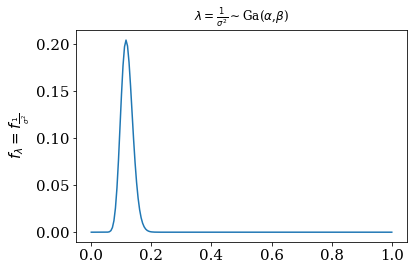

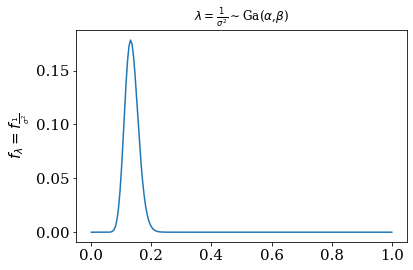

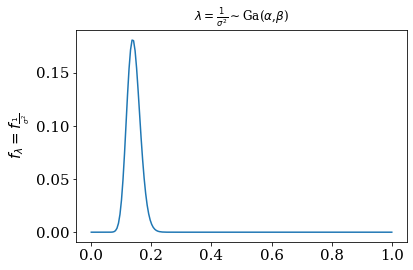

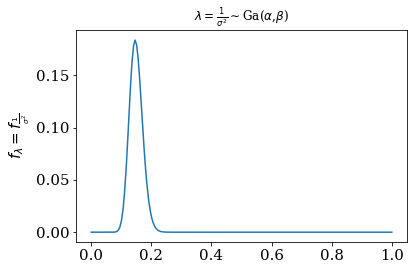

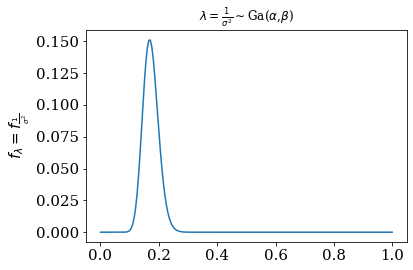

In [89]:
parameters_history
from scipy.stats import gamma


for epoch in range(10):
    plt.figure()
    
    distribution = gamma.pdf(np.linspace (0, 100, 200), 
                              a=np.abs(parameters_history[epoch][0])+1e-9, 
                              scale=1/(np.abs(parameters_history[epoch][1])+1e-9))

    plt.plot(np.linspace (0, 1, 200), distribution)
    plt.title("$\\lambda = \\frac{1}{\\sigma^2} \\sim $Ga($\\alpha$,$\\beta$)", size=12)
    plt.ylabel("$f_{\\lambda} = f_{\\frac{1}{\\sigma^2}}$", size=15)
    
    plt.rc('font', family='serif')
    plt.tight_layout()
    
    plt.show()

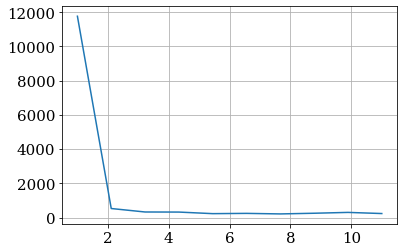

In [90]:


plt.figure()

plt.plot(np.linspace(1,11,10), l2loss_history)

plt.grid(True)

plt.show()